# Imports

In [44]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import librosa
import utils
from scipy import stats
import pyroomacoustics as pra
from network_lib import EndToEndLocModel, SampleCNNLoc
from tqdm import tqdm
from params import fs, window_size, min_src, max_src,n_mic, mics, c, composite_sample_cnn, composite_loc_cnn
from utils import normalize, denormalize
from zennit.attribution import Gradient
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 15})


In [256]:
source_fixed=True
source_fixed_num = 29

# Params

In [257]:
SNR = 10
T60=0.6
data_path = '/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/dataset2/val'
data_path = '/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/dataset2/test/SNR_'+str(SNR)+'_T60_'+str(T60)
files = [os.path.join(data_path,path) for path in os.listdir(data_path)]
figsize=(3,1.5)

# LOC-CNN model
Taken from: Vera-Diaz, Juan Manuel, Daniel Pizarro, and Javier Macias-Guarasa. "Towards end-to-end acoustic localization using deep learning: From audio signals to source position coordinates." Sensors 18.10 (2018): 3418. https://www.mdpi.com/1424-8220/18/10/3418

In [258]:
# Load network model
saved_model_path_loc_cnn='/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/models/model_SNR_'+str(SNR)+'_T60_'+str(T60)+'.pth'

model_loc_cnn = EndToEndLocModel()
model_loc_cnn.load_state_dict(torch.load(saved_model_path_loc_cnn))
model_loc_cnn.eval()

EndToEndLocModel(
  (conv1): Conv1d(16, 96, kernel_size=(7,), stride=(1,), padding=same)
  (conv2): Conv1d(96, 96, kernel_size=(7,), stride=(1,), padding=same)
  (conv3): Conv1d(96, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3712, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
  (dr1): Dropout1d(p=0.5, inplace=False)
  (activation1): ReLU()
  (activation2): ReLU()
  (activation3): ReLU()
  (activation4): ReLU()
  (activation5): ReLU()
  (activation6): ReLU()
)

In [259]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Network parameters for LOC-CNN: '+str(count_parameters(model_loc_cnn)))

Number of Network parameters for LOC-CNN: 2126355


### Localize one random source

In [48]:
idx_file = np.random.randint(0,len(files))
data_structure = np.load(str(files[idx_file]))
win_sig = data_structure['win_sig']
N_wins = win_sig.shape[-1]
idx_slice = np.random.randint(0,N_wins)
input_win_sig = win_sig[:,:,idx_slice]
src_loc_gt = data_structure['src_pos']
with torch.no_grad():
    est_pos = model_loc_cnn(torch.Tensor(input_win_sig).unsqueeze(0))

0.24895294233275747


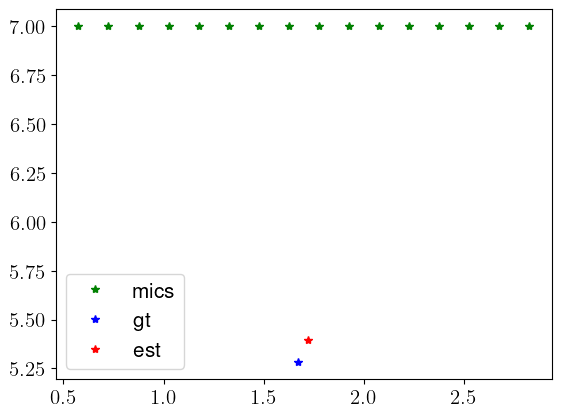

In [49]:

est_pos = est_pos.detach().numpy()[0]

plt.figure()
plt.plot(mics[0,:],mics[1,:],'g*')
plt.plot(src_loc_gt[0],src_loc_gt[1],'b*')
plt.plot(est_pos[0],est_pos[1],'r*')
plt.legend(['mics','gt','est'])

print(str(np.linalg.norm(est_pos-src_loc_gt)))

### Localize all sources per each window

In [50]:
sources_est = []
sources_gt = []
N_sources = len(files)
for n_s in tqdm(range(len(files))):
    data_structure = np.load(str(files[n_s]))
    win_sig = data_structure['win_sig']

    N_wins = win_sig.shape[-1]
    sources_win = []

    for n_w in range(N_wins):
        input_win_sig = win_sig[:,:,n_w]
        with torch.no_grad():
            est_pos = model_loc_cnn(torch.Tensor(input_win_sig).unsqueeze(0)).detach().numpy()[0]
        sources_est.append(est_pos)
        sources_gt.append(data_structure['src_pos'])
sources_est = np.array(sources_est)
sources_gt = np.array(sources_gt)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:29<00:00,  9.60it/s]


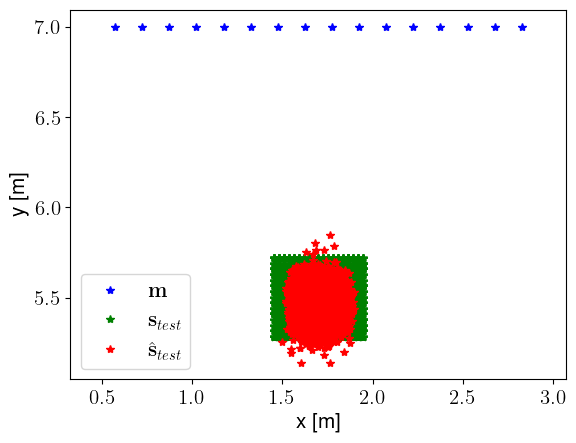

In [51]:
plt.figure()
plt.plot(mics[0,:],mics[1,:],'b*')
plt.plot(sources_gt[:,0],sources_gt[:,1],'g*')
plt.plot(sources_est[:,0],sources_est[:,1],'r*')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.legend(['$\mathbf{m}$','$\mathbf{s}_{test}$','$\hat{\mathbf{s}}_{test}$'], fontsize=15)
plt.axis('equal')
plt.show()


In [260]:
MAE = np.mean(np.mean(np.abs(sources_est-sources_gt),1))
print('MAE: '+str(MAE)+ '[m]')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

# SampleCNN model
Taken from: Sundar, Harshavardhan, et al. "Raw waveform based end-to-end deep convolutional network for spatial localization of multiple acoustic sources." ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2020. https://ieeexplore.ieee.org/abstract/document/9054090 

In [261]:
# Load network model
saved_model_path_sample_cnn='/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/models/samplecnn/model_SNR_'+str(SNR)+'_T60_'+str(T60)+'.pth'

model_sample_cnn = SampleCNNLoc()
model_sample_cnn.load_state_dict(torch.load(saved_model_path_sample_cnn))
model_sample_cnn.eval()

SampleCNNLoc(
  (BasicBlock1): BasicBlock(
    (conv): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=same)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (ReSE1): ReSE2Block(
    (BasicBlock): BasicBlock(
      (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (dropout): Dropout1d(p=0.2, inplace=False)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (SEBlock): SqueezeAndExcitationBlock(
      (globalAvgPooling): AvgPool1d(kernel_size=(1706,), stride=(1706,), padding=(0,))
      (dense1): Linear(in_features=128, out_features=128, bias=True)
      (activat

In [200]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Network parameters for SampleCNN: '+str(count_parameters(model_sample_cnn)))

Number of Network parameters for SampleCNN: 673475


### Localize one random source

In [55]:
idx_file = np.random.randint(0,len(files))
data_structure = np.load(str(files[idx_file]))
win_sig = data_structure['win_sig']
N_wins = win_sig.shape[-1]
idx_slice = np.random.randint(0,N_wins)
input_win_sig = win_sig[:,:,idx_slice]
src_loc_gt = data_structure['src_pos']
with torch.no_grad():
    est_pos = model_sample_cnn(torch.Tensor(input_win_sig).unsqueeze(0))

0.18061581756015432


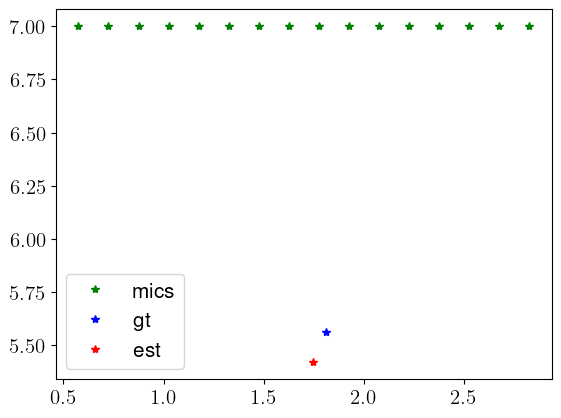

In [56]:

est_pos = est_pos.detach().numpy()[0]

plt.figure()
plt.plot(mics[0,:],mics[1,:],'g*')
plt.plot(src_loc_gt[0],src_loc_gt[1],'b*')
plt.plot(est_pos[0],est_pos[1],'r*')
plt.legend(['mics','gt','est'])

print(str(np.linalg.norm(est_pos-src_loc_gt)))

### Localize all sources per each window

In [57]:
sources_est = []
sources_gt = []
N_sources = len(files)
for n_s in tqdm(range(len(files))):
    data_structure = np.load(str(files[n_s]))
    win_sig = data_structure['win_sig']

    N_wins = win_sig.shape[-1]
    sources_win = []

    for n_w in range(N_wins):
        input_win_sig = win_sig[:,:,n_w]
        with torch.no_grad():
            est_pos = model_sample_cnn(torch.Tensor(input_win_sig).unsqueeze(0)).detach().numpy()[0]
        sources_est.append(est_pos)
        sources_gt.append(data_structure['src_pos'])
sources_est = np.array(sources_est)
sources_gt = np.array(sources_gt)


 12%|███████████████████████▊                                                                                                                                                                                | 34/285 [00:47<05:54,  1.41s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(mics[0,:],mics[1,:],'b*')
plt.plot(sources_gt[:,0],sources_gt[:,1],'g*')
plt.plot(sources_est[:,0],sources_est[:,1],'r*')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.legend(['$\mathbf{m}$','$\mathbf{s}_{test}$','$\hat{\mathbf{s}}_{test}$'], fontsize=15)
plt.axis('equal')
plt.show()


In [58]:
MAE = np.mean(np.mean(np.abs(sources_est-sources_gt),1))
print('MAE: '+str(MAE)+ '[m]')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

# Input Feature Inspection (LRP)

In [289]:
# Extract one random source
n_s = np.random.randint(len(files))
if source_fixed == True:
    n_s = source_fixed_num # N.B. Fixed if you want to reproduce paper exact same results!!!!!!
data_structure = np.load(str(files[n_s]))
win_sig = data_structure['win_sig']
sources_gt[n_s] = data_structure['src_pos']
N_wins = win_sig.shape[-1]


In [290]:
n_s

50

In [291]:
sources_gt[n_s]

array([1.48125   , 5.4375    , 1.23807996])

In [292]:
data = torch.permute(torch.Tensor(win_sig),(2,0,1))
output_gt = torch.unsqueeze(torch.Tensor(sources_gt[n_s] ),0)
output_gt = output_gt.repeat(N_wins,1)

### Loc-CNN

In [293]:
# Apply LRP
with Gradient(model=model_loc_cnn, composite=composite_loc_cnn) as attributor:
    out, relevance_loc_cnn = attributor(data, output_gt)

data = data.detach().numpy()
relevance_loc_cnn = relevance_loc_cnn.detach().numpy()

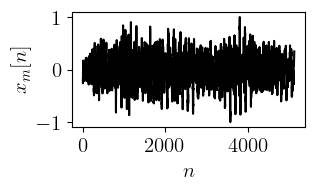

In [294]:
# Plot single window 
plt.figure(figsize=figsize)
plt.plot(utils.normalize(data[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_icassp/ex_input_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
plt.show()

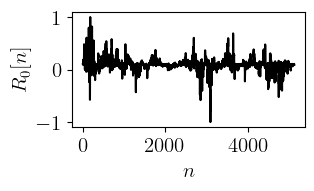

In [295]:
# Plot relevance map for the window
plt.figure(figsize=figsize)
plt.plot(utils.normalize(relevance_loc_cnn[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$R_0[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_relevance_loc_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')

plt.show()

### Sample-CNN

In [296]:
# Apply LRP
with Gradient(model=model_sample_cnn, composite=composite_sample_cnn) as attributor:
    out, relevance_sample_cnn = attributor(torch.Tensor(data), output_gt)

data = torch.Tensor(data).detach().numpy()
relevance_sample_cnn = relevance_sample_cnn.detach().numpy()

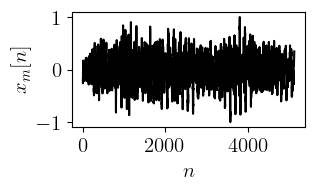

In [297]:
# Plot single window 
plt.figure(figsize=figsize)
plt.plot(utils.normalize(data[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_input_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
plt.show()

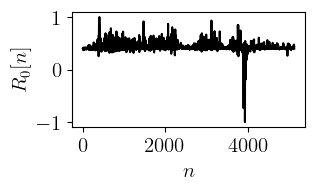

In [298]:
# Plot relevance map for the window
plt.figure(figsize=figsize)
plt.plot(utils.normalize(relevance_sample_cnn[1,0]),'k')
plt.xlabel('$n$')
plt.ylabel('$R_0[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_relevance_sample_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')

plt.show()

### GCC-PHAT visualization

In [299]:
idx_m1, idx_m2 = 5,10 # Microphone indices
audio_signal = data_structure['signal'][0] # In

# Reshape signal arriving at mic 1
win_sig_mic = data_structure['win_sig'][idx_m1]
win_sig_mic = np.transpose(win_sig_mic)
win_signal1 = np.reshape(win_sig_mic,window_size*N_wins)

# Reshape signal arriving at mic 2
win_sig_mic = data_structure['win_sig'][idx_m2]
win_sig_mic = np.transpose(win_sig_mic)
win_signal2 = np.reshape(win_sig_mic,window_size*N_wins) 

# LOC-CNN
# Reshape relevance relative to signal at mic 1
relevance_mic_loc_cnn = relevance_loc_cnn[:,idx_m1]
lrp_signal1_loc_cnn = np.reshape(relevance_mic_loc_cnn,window_size*N_wins)

# Reshape relevance relative to signal at mic 2
relevance_mic_loc_cnn = relevance_loc_cnn[:,idx_m2]
lrp_signal2_loc_cnn = np.reshape(relevance_mic_loc_cnn,window_size*N_wins)

# SAMPLE-CNN
# Reshape relevance relative to signal at mic 1
relevance_mic_sample_cnn = relevance_sample_cnn[:,idx_m1]
lrp_signal1_sample_cnn = np.reshape(relevance_mic_sample_cnn,window_size*N_wins)

# Reshape relevance relative to signal at mic 2
relevance_mic_sample_cnn = relevance_sample_cnn[:,idx_m2]
lrp_signal2_sample_cnn = np.reshape(relevance_mic_sample_cnn,window_size*N_wins)


# Compute STFT of signal
n_fft = 512
win_length=512
hop_length = win_length//4
WIN_STFT = librosa.stft(utils.normalize_z(win_signal1),n_fft=n_fft,win_length=win_length,hop_length=hop_length)
LRP_STFT_loc_cnn = librosa.stft(utils.normalize_z(lrp_signal1_loc_cnn),n_fft=n_fft,win_length=win_length,hop_length=hop_length)
LRP_STFT_sample_cnn = librosa.stft(utils.normalize_z(lrp_signal1_sample_cnn),n_fft=n_fft,win_length=win_length,hop_length=hop_length)


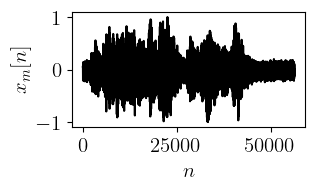

In [300]:
# Audio at microphones (reshaped to stack together different windows)
plt.figure(figsize=figsize)
plt.plot(utils.normalize(win_signal1),'k')
plt.xlabel('$n$')
plt.ylabel('$x_m[n]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_input_full_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
plt.show()

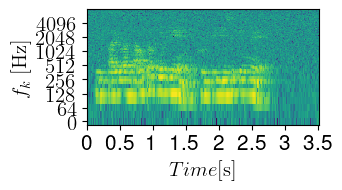

In [301]:
# STFT of audio at microphones
plt.figure(figsize=figsize)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(WIN_STFT),ref=np.max),hop_length=hop_length, x_axis='time', y_axis='log', sr=fs,cmap='viridis',win_length=win_length)
plt.xlabel('$Time [\mathrm{s}]$')
plt.ylabel('$f_k~[\mathrm{Hz}]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_stft_input_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')


In [302]:
import IPython.display as ipd
ipd.Audio(win_signal1, rate=fs) # load a NumPy array


### Relevance LOC-CNN

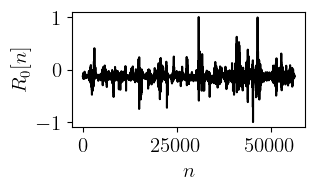

In [303]:
# Relevance at microphone (reshaped to stack together different windows)
plt.figure(figsize=figsize)
plt.plot(utils.normalize(lrp_signal1_loc_cnn),'k')
plt.xlabel('$n$')
plt.ylabel('$R_0[n]$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,0))
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_relevance_full_loc_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
plt.show()

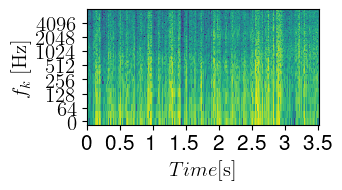

In [304]:
# STFT of Relevance at microphone 

plt.figure(figsize=figsize)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(LRP_STFT_loc_cnn),ref=np.max),hop_length=hop_length, y_axis='log',x_axis='time', sr=fs,cmap='viridis',win_length=win_length)
plt.xlabel('Samples')
plt.ylabel('$f_k~[\mathrm{Hz}]$')
plt.xlabel('$Time [\mathrm{s}]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_stft_relevance_input_loc_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
ipd.Audio(utils.normalize(lrp_signal1_loc_cnn) , rate=fs) # load a NumPy array


### Relevance SampleCNN

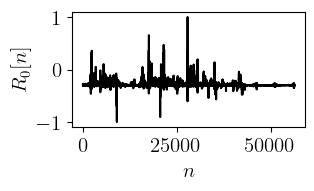

In [305]:
# Relevance at microphone (reshaped to stack together different windows)
plt.figure(figsize=figsize)
plt.plot(utils.normalize(lrp_signal1_sample_cnn),'k')
plt.xlabel('$n$')
plt.ylabel('$R_0[n]$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,0))
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_relevance_full_sample_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
plt.show()

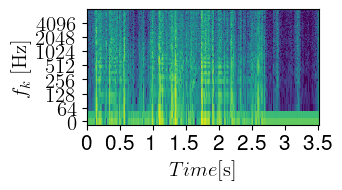

In [306]:
# STFT of Relevance at microphone 

plt.figure(figsize=figsize)
#librosa.display.specshow(librosa.amplitude_to_db(LRP_STFT_sample_cnn,ref=np.max), hop_length=128, y_axis='log',x_axis='time', sr=fs,cmap='viridis')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(LRP_STFT_sample_cnn),ref=np.max), hop_length=hop_length, y_axis='log',x_axis='time', sr=fs,cmap='viridis',win_length=win_length)

#librosa.display.specshow(20*np.log10(np.abs(LRP_STFT_sample_cnn)), hop_length=hop_length, y_axis='log',x_axis='time', sr=fs,cmap='viridis',win_length=win_length)

#plt.imshow(20*np.log10(np.abs(LRP_STFT_sample_cnn)))
plt.xlabel('Samples')
plt.ylabel('$f_k~[\mathrm{Hz}]$')
plt.xlabel('$Time [\mathrm{s}]$')
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_stft_relevance_input_sample_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')
ipd.Audio(utils.normalize(lrp_signal1_sample_cnn) , rate=fs) # load a NumPy array


### Plot GCC-PHAT

In [307]:
# Compute GCC-PHAT
_, gcc_sig = utils.gcc_phat(win_signal1, win_signal2, fs=fs)
_, gcc_lrp_loc_cnn = utils.gcc_phat(lrp_signal1_loc_cnn, lrp_signal2_loc_cnn, fs=fs)
_, gcc_lrp_sample_cnn = utils.gcc_phat(lrp_signal1_sample_cnn, lrp_signal2_sample_cnn, fs=fs)


In [308]:
# Ground-truth GCC-PHAT
gt_sig_1 = np.zeros_like(data[0,idx_m2])
gt_sig_2 = np.zeros_like(data[0,idx_m2])
dist_samples_1 = int((np.linalg.norm(sources_gt[n_s]  - mics[:,idx_m1])/c) * fs)
dist_samples_2 = int((np.linalg.norm(sources_gt[n_s]  - mics[:,idx_m2]) /c)*fs)
gt_sig_1[dist_samples_1] = 1/(4*np.pi*dist_samples_1)
gt_sig_2[dist_samples_2] = 1/(4*np.pi*dist_samples_2)
_, gcc_gt = utils.gcc_phat(gt_sig_2, gt_sig_1, fs=fs)



In [309]:
# Consider only samples contained in between mic distance
dist_mic_samples = (np.linalg.norm(mics[:,idx_m1]-mics[:,idx_m2])/c)*fs *2

gcc_sig_plot = gcc_sig[int(len(gcc_sig)/2 - dist_mic_samples):int(len(gcc_sig)/2+dist_mic_samples)]
gcc_gt_plot = gcc_gt[int(len(gcc_gt)/2 - dist_mic_samples):int(len(gcc_gt)/2+dist_mic_samples)]
gcc_lrp_plot_loc_cnn = gcc_lrp_loc_cnn[int(len(gcc_lrp_loc_cnn)/2 - dist_mic_samples):int(len(gcc_lrp_loc_cnn)/2+dist_mic_samples)]
gcc_lrp_plot_sample_cnn = gcc_lrp_sample_cnn[int(len(gcc_lrp_sample_cnn)/2 - dist_mic_samples):int(len(gcc_lrp_sample_cnn)/2+dist_mic_samples)]



ticks = ['$'+str(int(tick))+'$' for tick in np.arange(-dist_mic_samples,dist_mic_samples,dist_mic_samples*2/len(gcc_sig_plot))]

Text(0, 0.5, '$GCC-PHAT(\\ell)$')

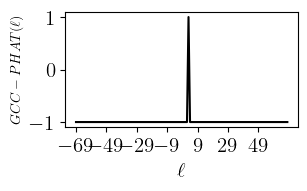

In [310]:
# Ground-truth GCC-PHAT
plt.figure(figsize=figsize)
plt.plot(utils.normalize(gcc_gt_plot),'k')
plt.xticks(np.arange(len(gcc_gt_plot))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)

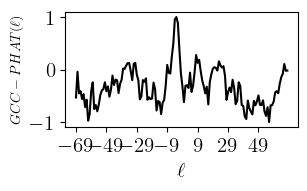

In [311]:
# Signal at microphones GCC-PHAT
plt.figure(figsize=figsize)
plt.plot(utils.normalize(gcc_sig_plot),'k')
plt.xticks(np.arange(len(gcc_sig_plot))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_gcc_input_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')


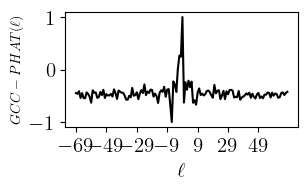

In [312]:
# LRP GCC-PHAT - LOC-CNN
plt.figure(figsize=figsize)
plt.plot(utils.normalize(gcc_lrp_plot_loc_cnn),'k')
plt.xticks(np.arange(len(gcc_lrp_plot_loc_cnn))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_gcc_relevance_loc_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')


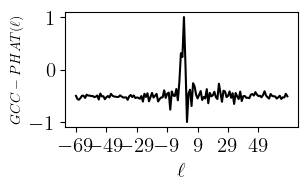

In [313]:
# LRP GCC-PHAT - SAMPLE-CNN
plt.figure(figsize=figsize)
plt.plot(utils.normalize(gcc_lrp_plot_sample_cnn),'k')
plt.xticks(np.arange(len(gcc_lrp_plot_sample_cnn))[0:-1:20],ticks[0:-1:20])
plt.xlabel('$\ell$')
plt.ylabel('$GCC-PHAT(\ell)$',fontsize=10)
plt.savefig('/nas/home/lcomanducci/xai_src_loc/endtoend_src_loc2/plots_spl/ex_gcc_relevance_sample_cnn_SNR_{}_T60_{}_n_source{}.pdf'.format(SNR,T60,n_s),bbox_inches='tight')


In [314]:
# Time Delay estimation
print('Estimated time-delay')
print('(GT): ' +str(np.argmax(gcc_gt)-(len(gcc_gt)/2))+' samples')
print('(Microphone signals): ' +str(np.argmax(gcc_sig)-(len(gcc_sig)/2))+' samples')
print('(Relevance signals LOC-CNN): ' +str(np.argmax(gcc_lrp_loc_cnn)-(len(gcc_lrp_loc_cnn)/2))+' samples')
print('(Relevance signals SAMPLE-CNN): ' +str(np.argmax(gcc_lrp_sample_cnn)-(len(gcc_lrp_sample_cnn)/2))+' samples')

Estimated time-delay
(GT): 3.5 samples
(Microphone signals): -4.5 samples
(Relevance signals LOC-CNN): -0.5 samples
(Relevance signals SAMPLE-CNN): 0.5 samples


In [315]:
T60

0.6

In [317]:
sources_gt[29]

array([1.48125   , 5.375     , 1.33693965])

In [318]:
sources_gt[50]

array([1.48125   , 5.4375    , 1.23807996])

In [319]:
sources_gt[70]

array([1.8640625 , 5.28125   , 1.41723473])